# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

EPS = 1.e-7

In [2]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        self.transforms = transforms
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

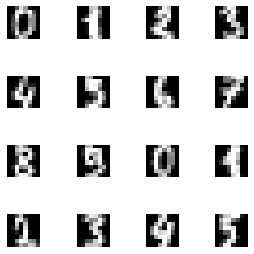

In [3]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4,4,figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4*i+j],(8,8))
        axs[i,j].imshow(img, cmap='gray')
        axs[i,j].axis('off')

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [21]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).

# This module reshapes an input (tensor -> matrix).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size # a list
  
    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)

# This module flattens an input (tensor -> matrix) by blending dimensions 
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
  
    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [22]:
#=========
# GRADING:
# 0 
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
#=========
# Implement a neural network (NN) classifier. 

class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction='none') #it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # based on inputs x, a class prediction y is produced 
        y_pred = self.classnet(x)
        y_preds = torch.tensor([torch.argmax(pred) for pred in y_pred])
        return y_preds

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction='avg'):
        
        y_pred = self.classnet(x)
#         print(y_pred.shape)
        loss = self.nll(y_pred,y)
        
        
        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:**

In classification, loss (so the distance between predicted labels and the actual target labels) is used as an objective function. The goal when training the neural network is to minimize that loss, thereby creating predictions that are closer to the truth. nn.NLLLoss is a layer that returns the negative log likelihood (since the log likelihood is negative, we minimize the negative value) of class labels. Those class labels need to be softmax-activated, so their summed likelihood must sum to 1. In essence, the model outputs class probabilities of the ten different classes of digits and the nn.NLLLoss computes how far off those probabilities are from the one-hot labeled true class label. Mathematically, NLLLoss is computed according to the following formula:

$$L(\Theta)=-\sum_{n=1}^{N}(y_n \ln s_n+(1-y_n)\ln(1-s_n))$$

Let's consider the following example: Model prediction: $[0.02,0.01,0.97]$, target label: $[0,0,1]$. According to the formula, the likelihood for the model producing the actual class labels is calculated using the negative log of $0*0.02 + 0*0.01 + 1*0.97 =0.97$, so $-\log(0.97)\approx 0.03$. When taking a one-hot vector of a worse prediction, say $[0.3,0.5,0.2]$ given that the target vector is still $[0,0,1]$, then the NLLLoss would equate to $0*0.3 + 0*0.5 + 1*0.2 =0.2$ and $-\log(0.2)\approx 1.61$. Since it is a minimization objective, the prior label vector was much better than the latter, which is exactly what is desired since the first was a better prediction of the target label than the latter. nn.NLLLoss computes distance between the target label (actual class) and the predicted probabilities. This loss is then minimized over time such that the difference between predicted and actual label become smaller and smaller.

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** Yes, it is fine because the logarithm does not change the most probable label, it changes only the probability to the log-probability.

### 2.2 Evaluation

In [23]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
  # If available, load the best performing model
  if model_best is None:
    model_best = torch.load(name + '.model')
  
  model_best.eval()# set the model to the evaluation mode
  loss_test = 0.
  loss_error = 0.
  N = 0.
  # start evaluation
  for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
    # loss (nll)
    loss_test_batch = model_best.forward(test_batch, test_targets, reduction='sum')
    loss_test = loss_test + loss_test_batch.item()
    # classification error
    y_pred = model_best.classify(test_batch)
    
    e = 1.*(y_pred == test_targets)
    loss_error = loss_error + (1. - e).sum().item()
    # the number of examples
    N = N + test_batch.shape[0]
  # divide by the number of examples
  loss_test = loss_test / N
  loss_error = loss_error / N

  # Print the performance
  if epoch is None:
    print(f'-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}')
  else:
    if epoch % 10 == 0:
      print(f'Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}')

  return loss_test, loss_error

# An auxiliary function for plotting the performance curves
def plot_curve(name, signal, file_name='curve.pdf', xlabel='epochs', ylabel='nll', \
               color='b-', test_eval=None):
  # plot the curve
  plt.plot(np.arange(len(signal)), signal, color, linewidth='3', label=ylabel +' val')
  # if available, add the final (test) performance
  if test_eval is not None:
    plt.hlines(test_eval, xmin=0, xmax=len(signal), linestyles='dashed', label=ylabel\
               +' test')
    plt.text(len(signal), test_eval, "{:.3f}".format(test_eval),)
  # set x- and ylabels, add legend, save the figure
  plt.xlabel(xlabel), plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(name + file_name, bbox_inches='tight')
  plt.show()

### 2.3 Training procedure

In [25]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(name, max_patience, num_epochs, model, optimizer, training_loader, \
             val_loader):
  nll_val = []
  error_val = []
  best_nll = 1000.
  patience = 0

  # Main training loop
  for e in range(num_epochs):
    model.train() # set the model to the training mode
    # load batches
    for indx_batch, (batch, targets) in enumerate(training_loader):
      # calculate the forward pass (loss function for given images and labels)
      loss = model.forward(batch, targets)
      # remember we need to zero gradients! Just in case!
      optimizer.zero_grad()
      # calculate backward pass
      loss.backward(retain_graph=True)
      # run the optimizer
      optimizer.step()

    # Validation: Evaluate the model on the validation data
    loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
    nll_val.append(loss_e)  # save for plotting
    error_val.append(error_e)  # save for plotting

    # Early-stopping: update the best performing model and break training if no 
    # progress is observed.
    if e == 0:
      torch.save(model, name + '.model')
      best_nll = loss_e
    else:
      if loss_e < best_nll:
        torch.save(model, name + '.model')
        best_nll = loss_e
        patience = 0
      else:
        patience = patience + 1

    if patience > max_patience:
      break

  # Return nll and classification error.
  nll_val = np.asarray(nll_val)
  error_val = np.asarray(error_val)

  return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [26]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [27]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [28]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = (iter(training_loader)).next()
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1,8,8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [29]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64   # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10 # the number of labels
num_kernels = 32 #the number of kernels for CNN

# -> training hyperparams
lr = 1e-3 # learning rate
wd = 1e-5 # weight decay
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for 
                  # longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=3.1099076625279016, val ce=0.9285714285714286


/home/sid/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 10, val nll=1.4393455287388393, val ce=0.43714285714285717
Epoch: 20, val nll=0.6969543293544225, val ce=0.14
Epoch: 30, val nll=0.43190282549176895, val ce=0.09714285714285714
Epoch: 40, val nll=0.32706730433872766, val ce=0.08
Epoch: 50, val nll=0.272446391241891, val ce=0.07142857142857142
Epoch: 60, val nll=0.23980467660086496, val ce=0.07428571428571429
Epoch: 70, val nll=0.21578563145228793, val ce=0.06857142857142857
Epoch: 80, val nll=0.20036073752811978, val ce=0.06571428571428571
Epoch: 90, val nll=0.18536660671234131, val ce=0.05714285714285714
Epoch: 100, val nll=0.17890294688088554, val ce=0.05714285714285714
Epoch: 110, val nll=0.1731166594369071, val ce=0.05714285714285714
Epoch: 120, val nll=0.16740639890943254, val ce=0.05714285714285714
Epoch: 130, val nll=0.1620484413419451, val ce=0.05714285714285714
Epoch: 140, val nll=0.15733928612300327, val ce=0.05142857142857143
Epoch: 150, val nll=0.15578031267438616, val ce=0.05142857142857143
Epoch: 160, val nll=0.152

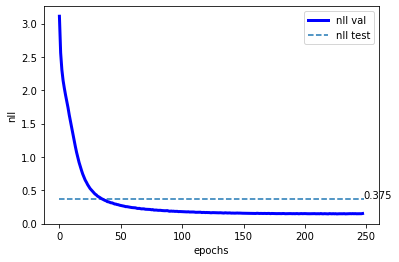

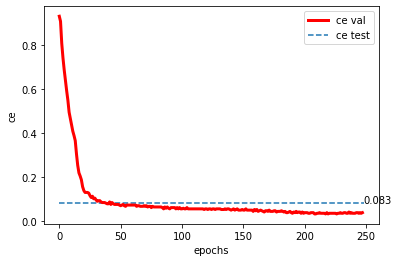


-> START classifier_cnn
Epoch: 0, val nll=2.0822217232840403, val ce=0.72


/home/sid/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 10, val nll=0.8210998426164899, val ce=0.12
Epoch: 20, val nll=0.45912420000348775, val ce=0.09142857142857143
Epoch: 30, val nll=0.32739845820835656, val ce=0.07142857142857142
Epoch: 40, val nll=0.2630504935128348, val ce=0.06857142857142857
Epoch: 50, val nll=0.225377562386649, val ce=0.06571428571428571
Epoch: 60, val nll=0.20220616340637207, val ce=0.06
Epoch: 70, val nll=0.18624019350324358, val ce=0.05714285714285714
Epoch: 80, val nll=0.1720313004084996, val ce=0.05714285714285714
Epoch: 90, val nll=0.16329002516610283, val ce=0.05714285714285714
Epoch: 100, val nll=0.1561818858555385, val ce=0.05714285714285714
Epoch: 110, val nll=0.14905291557312011, val ce=0.054285714285714284
Epoch: 120, val nll=0.1459029177256993, val ce=0.05142857142857143
Epoch: 130, val nll=0.14271036079951696, val ce=0.05142857142857143
Epoch: 140, val nll=0.1405486031941005, val ce=0.05142857142857143
Epoch: 150, val nll=0.13777614116668702, val ce=0.05142857142857143
Epoch: 160, val nll=0.1361

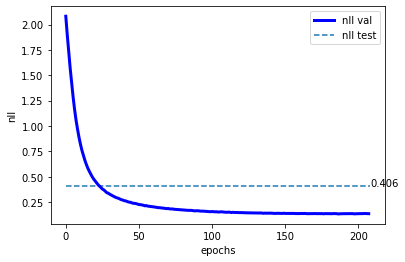

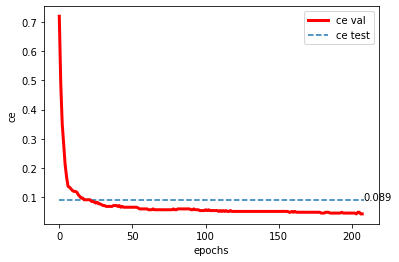

In [30]:
import math
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = [
         'classifier_mlp', 
         'classifier_cnn']


# names = ['classifier_cnn']

# loop over models
for name in names:
    print('\n-> START {}'.format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == 'classifier_mlp':
        name = name + '_M_' + str(M)
    elif name == 'classifier_cnn':
        name = name + '_M_' + str(M) + '_kernels_' + str(num_kernels)


  # Create a folder if necessary
    results_dir = './content/'
    result_dir = os.path.join(os.getcwd(), 'results')
    if not(os.path.exists(result_dir)):
        os.mkdir(result_dir)

  # MLP
    if name[0:14] == 'classifier_mlp':
        #=========
        # GRADING: 
        # 0
        # 0.5pt if properly implemented
        #=========
        #------
        # PLEASE FILL IN:
        # classnet = nn.Sequential(...)
        #
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        #------
        classnet = nn.Sequential(
            nn.Linear(D,16),
            nn.ReLU(16),
            nn.Linear(16,K),
            nn.LogSoftmax(),
        )

    # CNN
    elif name[0:14] == 'classifier_cnn':

        #=========
        # GRADING: 
        # 0
        # 0.5pt if properly implemented
        #=========
        #------
        # PLEASE FILL IN:
        
       
        classnet = nn.Sequential(
            Reshape(size=(1,8,8)),
            nn.Conv2d(1, 2, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(2),
            nn.ReLU(inplace=True),
            Flatten(),
            nn.Linear(162,K),
            nn.LogSoftmax()
        )
        pass
        #
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        #------

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)  
    

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax([p for p in model.parameters() 
                                    if p.requires_grad == True], lr=lr, weight_decay=wd) 

    # Training procedure
    nll_val, error_val = training(name=result_dir + name,
                                max_patience=max_patience,
                                num_epochs=num_epochs,
                                model=model,
                                optimizer=optimizer,
                                training_loader=training_loader,
                                val_loader=val_loader)
  
    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + '_test_loss.txt', "w")
    f.write('NLL: ' + str(test_loss) + '\nCE: ' + str(test_error))
    f.close()
    # create curves
    plot_curve(result_dir + name, nll_val, file_name='_nll_val_curve.pdf', ylabel='nll', 
               test_eval=test_loss)
    plot_curve(result_dir + name, error_val, file_name='_ca_val_curve.pdf', ylabel='ce', 
               color='r-', test_eval=test_error)

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: 

The plot of the nll-loss depicts how far off the predicted class probabilities are from the target label. The following plot shows the reduction of that loss during the training of the MLP and CNN models respectively.

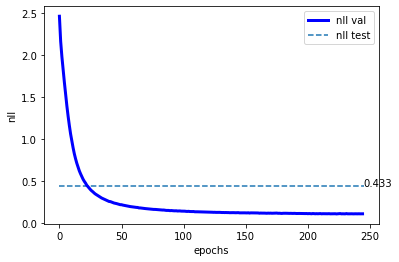
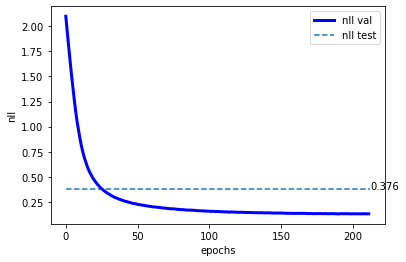

As becomes evident in the plots, the speed of convergence displayed by the shape of the curve is relatively similar in both models. The difference between the two is the final loss to which the two models converge. The MLP (left) has a higher overall loss, even though it converges with a similar speed, it comes close to a worse overall loss than the CNN model (right). The testing loss depicted by the dashed blue line in both plots shows this difference as well; the MLP plot has a higher (i.e. worse) nll loss which means that its predictions are further off from the target label than the CNN model. 

The plots also show that both models are overfitting on the training data since they are converging towards some error on the training data that lies below the testing error by a significant margin. A reason for this might be that when creating testing and training data by splitting it on arbitrary values in the dataset, the testing data might be biased towards some digit that is underrepresented in one of the two parts.

Classification error is the proportion of instances misclassified over the whole dataset. The two plots below show the classification error (ce) of the MLP (left) and CNN (right) model:

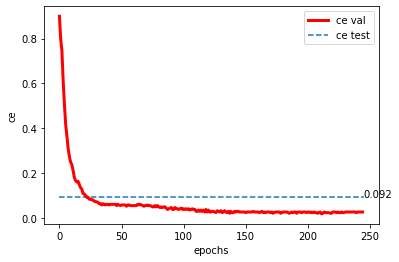
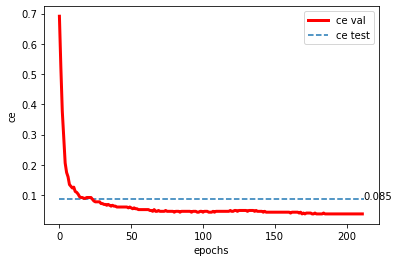

Evidently, the CNN model converges slightly faster towards a better (lower) classification error, since the right curve is descending faster than the left. Overall, both models seem to have similar classification errors on the testing set. Just as seen with the nll plots, these models are overfitting on the training data since they are converging towards some error significantly below the testing error. Further, the error rates are not decreasing drastically over time which suggests that training could have been stopped half way into the process.  

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: In my implementation, the CNN does not perform much better than the MLP structure. Given a better / more thorough implementation of both network types, the CNN will eventually outperform the MLP since it can focus on subparts images. In general, image classification is generally tackled with CNNs since they are very effective in reducing the number of parameters of the picture without downgrading the performance of models. Using MLP for the same purpose ends up being very costly in terms of computation since the number of parameters becomes large. Another advantage of CNNs is that nearby pixels are more strongly related than distant ones due to parameter sharing of the kernels which end up looking for specific patterns in the image which  is location invariant.


## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

In [13]:
from sklearn.model_selection import train_test_split
import scipy.io
import numpy as np
import torchvision.transforms as Transformer


class Housenumbers(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):       
        # copied from original class, does not have influence on my code.
        self.transforms = transforms 
        
        # pull training data from matlab files using self-made function
        train_pixels, train_targets = self.load_svhn(os.getcwd())
        test_pixels, test_targets = self.load_svhn(os.getcwd(),split='test')
        
        # randomly splitting off validation data used to test performance during training
        # placing randomstate = 42 to ensure that the same set of validation is used 
        # in the case that the class is instantiated several times
        train_pixels, val_pixels, train_targets, val_targets = train_test_split(
                                                            train_pixels,
                                                            train_targets,
                                                            test_size=0.2,
                                                            random_state=42)
        # store training data
        if mode == 'train':
            self.data = train_pixels
            self.targets = train_targets
        # store validation data
        elif mode == 'val':
            self.data = val_pixels
            self.targets = val_targets
        # store testing data
        elif mode == 'test':
            self.data = test_pixels
            self.targets = test_targets
        # catch case that unknown mode has been entered
        else:
            raise Exception('Unkown mode. Cannot create data.')
        print(f'{mode} data created')
        
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)
    
    # function that takes in a dataset in the form of
    # [N, pic_height, pic_width, nr_dim] (numpy format)
    # and returns 
    # [N, nr_dim, pic_height, pic_width] (torch format)
    # additionally, all values are transformed to floats
    def transform_to_torch_tensor(self, dataset):
            # use transformer module as basis for tensor transformation
            transform = Transformer.ToTensor()
            l = [transform(i).float() for i in dataset]
            return torch.stack(l)
    
    # function that reads the training data from the downloaded files
    def load_svhn(self, image_dir, split='train'):
        # depending on the split, open the two different files
        image_file = 'train_32x32.mat' if split=='train' else 'test_32x32.mat'
        image_dir = os.path.join(image_dir, image_file)
        # open file in matlab format
        matlab_labels = scipy.io.loadmat(image_dir)
        # transform to numpy
        labels = matlab_labels['y'].reshape(-1)
        # set labels==10 to labels 0
        labels[np.where(labels==10)] = 0
        # transpose to numpy format
        images_np = np.transpose(matlab_labels['X'], [3, 0, 1, 2]) / 255
        # transpose to torch format -> tensor
        torch_pixels = self.transform_to_torch_tensor(images_np)
        
        return torch_pixels, labels

In [14]:
# create data instances for the different modes used during training and
# testing of the CNN
train_data = Housenumbers(mode='train')
val_data = Housenumbers(mode='val')
test_data = Housenumbers(mode='test')
print('done')

train data created
val data created
test data created
done


In [15]:
# load the created datasets into the DataLoader that provides the data
# during both the training as well as the testing process
training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Epoch: 0, val nll=1.5077853115601452, val ce=0.4658067158067158
Epoch: 10, val nll=0.3705384754073643, val ce=0.10722085722085722
Epoch: 20, val nll=0.30844691973418575, val ce=0.09125034125034125
Epoch: 30, val nll=0.2903008210815239, val ce=0.08394758394758395
Epoch: 40, val nll=0.26781663268503514, val ce=0.07862407862407862
Epoch: 50, val nll=0.26282472894258785, val ce=0.07527982527982528
Epoch: 60, val nll=0.25522669928502817, val ce=0.07371007371007371
Epoch: 70, val nll=0.2525015722816836, val ce=0.07241332241332242
Epoch: 80, val nll=0.25185431283727033, val ce=0.07152607152607153
Epoch: 90, val nll=0.24605193535242775, val ce=0.06975156975156975
Epoch: 100, val nll=0.24496905709668454, val ce=0.06859131859131859
Epoch: 110, val nll=0.24687537561909864, val ce=0.06988806988806989
Epoch: 120, val nll=0.23474728057139108, val ce=0.0662025662025662
Epoch: 130, val nll=0.23922498377333434, val ce=0.0679088179088179
Epoch: 140, val nll=0.23359165512739294, val ce=0.0656565656565656

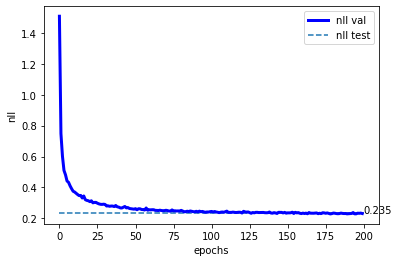

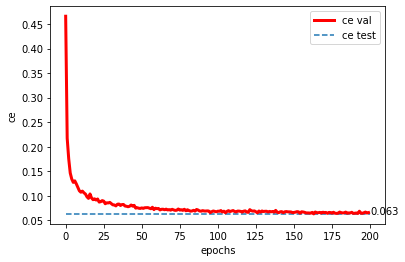

In [19]:
# create CNN class, inherit NN class from torch
class HousenumberCNN(nn.Module):
    def __init__(self, classnet):
        # init super (parent) class
        super().__init__()
        # import set of layers that was designed
        self.classnet = classnet
        # import loss function
        self.nll = nn.NLLLoss(reduction='none')

    # This function classifies an image x to a class.
    def classify(self, x):
        # based on inputs x, a class prediction y is produced 
        # my multiplying the differnt layers based on the weights
        y_pred = self.classnet(x)
        # get a label in format long from the prediction
        y_preds = torch.tensor([torch.argmax(pred) for pred in y_pred])
        return y_preds # returns label

    # This class outputs a value of the loss function.
    def forward(self, x, y, reduction='avg'):
        
        # get a label prediction of the set of layers that was created
        y_pred = self.classnet(x)
        # calculate the distance between calculated probabilities y_pred
        # and onehot vector y that encodes the actual label of the picture
        loss = self.nll(y_pred,y)
        
        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()
# initialize the sequence of layers of my CNN. 
# their detailed functionality will be explained in a cell below
classnet = nn.Sequential(
        nn.Conv2d(3,32,kernel_size = (3,3), padding='same'),
#         nn.BatchNorm2d(32),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = (2,2)),
        nn.Dropout(0.3),
        nn.Conv2d(32,64, kernel_size = (3,3), padding='same'),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = (2,2)),
        nn.Dropout(0.3),
        nn.Conv2d(64,128,kernel_size = (3,3), padding='same'),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = (2,2)),
        nn.Dropout(0.3),
        Flatten(),
        nn.ReLU(2048),
        nn.Dropout(0.4),
        nn.Linear(2048,10),
        nn.LogSoftmax(dim=1)
    )

# initialiaze the model class
model = HousenumberCNN(classnet)
# initilalize the optimizer
optimizer = torch.optim.Adamax([p for p in model.parameters() 
                                if p.requires_grad == True], lr=lr, weight_decay=wd) 

# Training procedure
nll_val, error_val = training(name=result_dir + name,
                            max_patience=max_patience,
                            num_epochs=num_epochs,
                            model=model,
                            optimizer=optimizer,
                            training_loader=training_loader,
                            val_loader=val_loader)

# The final evaluation (on the test set)
test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
plot_curve(result_dir + name, nll_val, file_name='_nll_val_curve.pdf', 
           ylabel='nll', test_eval=test_loss)
plot_curve(result_dir + name, error_val, file_name='_ca_val_curve.pdf', 
           ylabel='ce', color='r-', test_eval=test_error)

##### (1pt) Provide a good explanation of the applied architecture and a description of all components.

I find it more sensible to first talk about the applied architecture and then continue with talking about the possible improvements. Hence, I will now explain the CNN structure that I came up with.

Overall, there are a total of three convolutional layers applied in the structure. Due to their specific functionality, they have great power of understanding substructures in a picture and thereby form the main component (and the naming source) of CNNs. A convolutional layer contains a set of kernels whose parameters are improved during training. The size of the filters is significantly smaller which leads to the kernels analyzing a subpart of the pixels of the actual image. Each filter convolves with the current number of layers (initially three for red, green and blue components) of the image and creates an activation map from them, thereby creating a larger set of layers that encode certain information of the set of pixels. For my implementation, I found that a kernel size of 3 by 3 pixels works well.

Every application of a convolutional layer was followed by a pass through a rectified linear unit (ReLU) activation function. An activation function receives the layer's output and converts it according to a certain formula. ReLU applies $f(x) = \begin{cases} x & \text{for } x \geq 0 \\ 0 & \text{for } x < 0 \end{cases} = \max(0,x)$. This activation function can be understood as returning the input if it is positive and not equal 0 and returning 0 in all other cases. Activation functions in general enable neural networks (that would otherwise simply be overcomplex expressions of basic linear regression) convergence towards problems of higher complexity that go beyond linear. ReLU was proposed because it eliminated the vanishing gradient problem of the otherwise popular sigmoid and tanh introduced through the use of many layers. Both sigmoid as well as tanh are very sensitive for values around their midpoint (0.5 for sigmoid and 0 for tanh) but make values snap to their extremes. When backpropagating error values, deep neural networks with many layers are less functional because cells fail to pass the gradient back in order to update the weights. Another advantage of ReLU is the computational simplicity since taking the maximum value of the input value and 0 is cheap to compute. It was generally found that working with ReLU allowed for faster convergence and more optimal performance in most cases. After some testing I can confirm these findings for my CNN structure.

There are several max pooling layers in my CNN that I utilize to reduce the size of feature layers after they were created by convolution. This layer works by comparing a number of adjacent node values (in my case, I found a window size of 2 by 2 to be benefitial) and taking the maximum of that neighborhood as the new value. Next, the window comparing the neighboring values moves with a stride of the window dimensions (so not overlapping) further and repeats its max pooling procedure. This achieves a shrinking of parameter values (in my case, four values are combined to one) which combats computational expense as well as overfitting. 

Another element that is part of my structure is a dropout layer that randomly deactivates neurons and disable them from passing on their value down the network. By appling this type of layer, the network learning is forced to not simply focus on few important nodes but rather on a broad spectrum of them since focussing the information on one node is disadvantageous in the case that in a random iteration, the node is deactivated. This process avoids overfitting. Without the dropout layers, I found the network to converge faster towards a classification error of around $0.1$ but then not improving further but rather having more trouble classifying validation data. With the introduction of the dropout layers, the network converged slower towards $0.1$ error-margin but did not have any difficulty lowering the error to below $0.07$. These findings coincide with the explanation; the network has more information available and can therefore learn relationships faster, but with more time, a network with dropout will likely perform better since it does not overfit on the training data.

After having applied a number of convoluations, thereby producing a variety of layers each encoding some feature of the images, the information needs to be transformed to an output that enables the classfication of an input image. In CNNs, this is usually achieved by connecting all feature values (nodes) produced by the last convolutional layer (and the application of activation functions and/or dropouts and/or pooling operations) to a set of nodes that represent the number of classes of the data. In my case, there were $2048$ nodes with encoded information left of which I connected every node to every one of the $10$ output nodes (encoding the $10$ digits). A total of $10*2048=20480$ weights were used for this operation, totally connecting to the output nodes.

For the latter operation to be possible, I also applied a layer that "flattened" the nodes to one vector. In the last convolutional layer, a network can have multidimensional matrices (pytorch tensors) encoding information. These values need to be lined up into one line of values (vector) in order to be connected to the linear layer that fully connects the nodes to the 10 classifying output nodes.

The 10 output nodes do not represent class probabilities when they are computed in their raw format by the fully connected layer. Instead, they can be values in any range and must therefore be converted to class probabilities that are interpretable. After being passed through a log-softmax function $(\text{SoftMax}(x_i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)})$, the values are normalized to a set of scalars in the range between 0 and 1 which sum to 1. Due to this format, they can be interpreted as probabilities of a class given a set of input values. The distance of this class-probability-vector and the one-hot vector encoding the target class can be calculated during training and is represented by the earlier described nll-loss depicted in the upper plot above.

##### (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).

I believe that an extra component could be batch normalization. This technique introduced in 2015 [ https://arxiv.org/abs/1502.03167 ] works by calculating the mean and standard deviation of all input variables given a set of inputs (mini-batch) and using statistics to perform standardization. After training, the mean and stds of the inputs for the layer can be set as mean values that were observed over the training set. As explained in the original paper, this technique is "dramatically accelerating the training of deep networks." And "merely adding Batch Normalization to a state-of-theart image classification model yield[ed] a substantial speedup in training." Due to their findings, I am confident that with proper tuning and some adjustments that would be needed no be done to the code (instead of simply adding it to the classnet), the training of the CNN can be drastically improved as well.

##### (2pt) Analyze the results.

I think generally, my results are quite good. In the two graphs below, we see that the model converged to a very low loss and classification error during training. The goal for the classification error was 0.1 (later even raised to 0.2), which my CNN did achieve with ease (0.065 on average over multiple runs). This means that the trained model can be used to effectively classify pictures of digits on house walls. We can conclude this with high confidence, because the model achieved the low classification error on the test-set, which means that it is very unlikely that the CNN overfitted on the training data. Furthermore, the loss and classification error were very similar on the training and validation set compared to the test-set, which further speaks to the fact that the model did not overfit (visible in that both loss and error converge during training towards the value calculated on the test set). 

Overall, I am very happy with the CNN that I implemented, because regardless of its simple structure, it achieved a high performance, which reduces the time that it takes to train the model. 

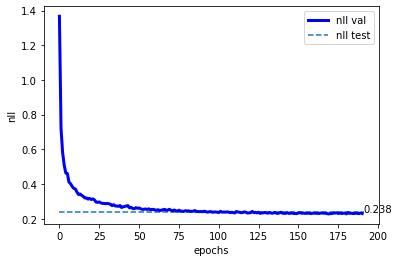
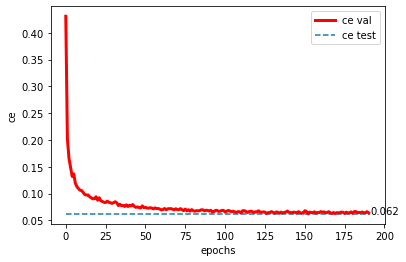